# Basic workflow with ART for evasion attacks and defenses

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from os.path import join, abspath, expanduser
import numpy as np
import matplotlib.pyplot as plt

import keras.backend as k
from keras.applications import vgg16
from keras.preprocessing import image
from keras.utils import np_utils

from art.attacks import ProjectedGradientDescent

# Install Imagenet stubs
import sys
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

Using TensorFlow backend.


  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-vhktur21
  Running command git clone -q https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-vhktur21
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-cp36-none-any.whl size=794842 sha256=376650fd08849ece31dc07ffc943a74cdc0d9814e032748b14a0fbe0efd072ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-kz_kll7g/wheels/ae/51/e7/c1cfa8692ea864410aa778b169fc7766af073ac52a1bc23301
Successfully built imagenet-stubs


## Import a standard visual recognition model

Here, we will use Keras as backend and ImageNet as dataset. We load the standard ResNet50 model from Keras.

In [2]:
# Load model
from keras.applications.resnet50 import ResNet50, preprocess_input
from art.classifiers import KerasClassifier

# Load model
mean_imagenet = np.zeros([224, 224,3])
mean_imagenet[...,0].fill(103.939)
mean_imagenet[...,1].fill(116.779)
mean_imagenet[...,2].fill(123.68)
model = ResNet50(weights='imagenet')
classifier = KerasClassifier(clip_values=(0, 255), model=model, preprocessing=(mean_imagenet, 1))

# Imagenet training images

In [3]:
images_list = list()

for image_path in imagenet_stubs.get_image_paths():
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    images_list.append(im)

images = np.concatenate(images_list, axis=0)

# Evaluate model on images

Prediction: tractor - confidence 0.76


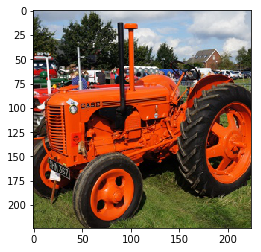

In [4]:
# Show clean image
plt.imshow(images[0] / 255)

# Prediction for clean image
pred = classifier.predict(images[0:1])
label = np.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]
print('Prediction:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))

## Perform evasion attack

Prediction: plow, plough - confidence 0.80


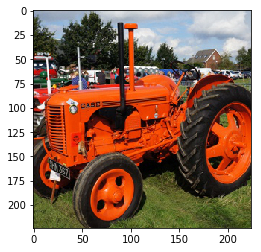

In [5]:
# Create attacker
adv = ProjectedGradientDescent(classifier, targeted=False, eps_step=1, eps=4, max_iter=1)

# Generate attack image
img_adv = adv.generate(images[0:1])

# Evaluate it on model
pred_adv = model.predict(img_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))
plt.imshow(img_adv[0] / 255);

## Compute attack statistics

We can measure the quantity of noise that was introduced to the image by the attack under different $L_p$ norms. Notive that the projected gradient descent attacks optimizes the $L_0$ norm.

Noise L_0 norm: 98%
Noise L_2 norm: 1%
Noise L_inf norm: 1%


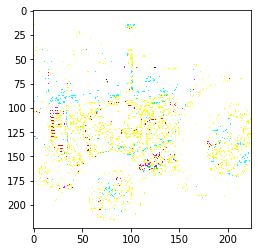

In [6]:
import numpy as np

l0 = int(99*len(np.where(np.abs(images[0] - img_adv[0])>0.5)[0]) / (224*224*3)) + 1   
l1 = int(99*np.sum(np.abs(images[0] - img_adv[0])) / np.sum(np.abs(images[0]))) + 1
l2 = int(99*np.linalg.norm(images[0] - img_adv[0]) / np.linalg.norm(images[0])) + 1 
linf = int(99*np.max(np.abs(images[0] - img_adv[0])) / 255) + 1
print('Noise L_0 norm: %d%%' % l0)
print('Noise L_2 norm: %d%%' % l2)
print('Noise L_inf norm: %d%%' % linf)
plt.imshow(np.abs(images[0] - img_adv[0]));

## Apply defense

We apply feature squeezing as defense before putting the attack image into the classification model. This defense reduces the colour depth of the image. Here, each colour channel will be encoded on 4 bits (`bit_depth=4`). Notice that the prediction is now correct again, albeit with lower confidence value than on the clean image.

Prediction: plow, plough - confidence 0.68


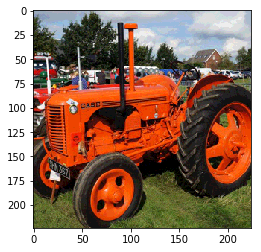

In [7]:
from art.defences import FeatureSqueezing

fs = FeatureSqueezing(bit_depth=4, clip_values=(0, 255))
img_def, _ = fs(img_adv)
pred_def = model.predict(img_def)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]
print('Prediction:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
plt.imshow(img_def[0] / 255);